In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import signal
import statsmodels.api as sm
from matplotlib import pyplot as plt

# A few test imports that aren't needed
# df_m = pd.read_csv('https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv',parse_dates=True, index_col=1)

In [3]:
#This function is used to transform the FRED DB
#https://www.ssc.wisc.edu/~bhansen/econometrics/FRED-MD_description.pdf
def transform(column, transforms,dfreq):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if dfreq == 'Q' else 1

    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
    #Annual percent change
    elif transformation == 8:
        column = np.log(column).diff(4) * 100 
        
    return column


In [4]:
#Function for pulling the FRED data bases

def load_fredmd_data(vintage):
    base_url = 'https://files.stlouisfed.org/files/htdocs/fred-md'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # # 3. Extract the date as an index
    # orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    # orig_m.drop('sasdate', axis=1, inplace=True)
    orig_m['sasdate'] = pd.to_datetime(orig_m['sasdate'],format='%m/%d/%Y')
    orig_m.set_index('sasdate',inplace=True)
    #orig_m.drop('sasdate', axis=1, inplace=True)
   

    #4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m,dfreq ='M')

  
    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    orig_q.iloc[1:'GDPC1'] = 8
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    # orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    # orig_q.drop('sasdate', axis=1, inplace=True)
    orig_q['sasdate'] = pd.to_datetime(orig_q['sasdate'],format='%m/%d/%Y')
    orig_q.set_index('sasdate',inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q,dfreq ='Q')


    # - Output datasets ------------------------------------------------------
    return dta_m,dta_q

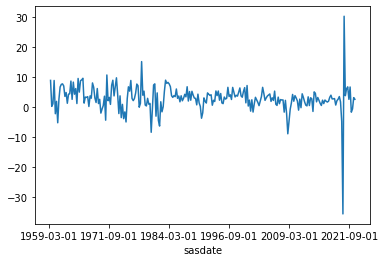

In [5]:
#User option to recollect the fresh data:
pull_data = 0

if pull_data:
    df_m,df_q = load_fredmd_data('2023-02')
    df_m.to_csv('temp/df.csv')
    df_q.to_csv('temp/df_q.csv')
else:
    df_m = pd.read_csv('temp/df.csv')
    df_q = pd.read_csv('temp/df_q.csv')
    
    
df_m.set_index('sasdate',inplace=True)
df_q.set_index('sasdate',inplace=True)
df_q = df_q['GDPC1']
df_q.plot()

#Merge on the quarterly data
df = pd.merge(df_m, df_q, left_index=True, right_index=True,how='left')

#Add the QGDP as the target
df['GDPC1_continuous']= df['GDPC1'].fillna(method="bfill")
df['GDPC1_continuous_lag']= df['GDPC1_continuous'].shift(3)

#Add day of week feature etc.
df['date'] = pd.to_datetime(df.index,format = '%Y-%m-%d')
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
DeleteList=['date']
df=df.drop(DeleteList, axis=1)

df_raw = df

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

df = df_raw.loc['1995-01-01':'2020-01-01'].copy()

split_date = '2012-1-1'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

target = 'GDPC1_continuous'
lag_length = 12
glob_list = list(df.columns.values)

glob_list.remove(target)
glob_list.remove('GDPC1')

def create_features(df,target,predictors,lag_order):
    """
    Creates time series features from datetime index
    """
 
    df_reg = df.copy()
    reglist = list()
    
    for f in glob_list:
        for i in range(0,lag_order):
            varname = f'{f}_L_{i}'
            reglist.append(varname)
            #df_reg[varname] = df_reg[f].shift(i) 
            df_reg[varname] = df_reg[f].shift(i) 
            
    #df_reg = df_reg.iloc[lag_order:,:]
    X = df_reg[reglist]
    y = df_reg[target]
    return X, y
    

X_train, y_train = create_features(df_train, target,glob_list,lag_length)
X_test, y_test = create_features(df_test, target,glob_list,lag_length)

/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_61762/1721599178.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_reg[varname] = df_reg[f].shift(i)
/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_61762/1721599178.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_reg[varname] = df_reg[f].shift(i)
/var/folders/3_/4hp02k9s28l0xngsnvfp3jl40000gn/T/ipykernel_61762/1721599178.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [7]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=False) # Change verbose to True if you want to see it train

/Users/wcrossb/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

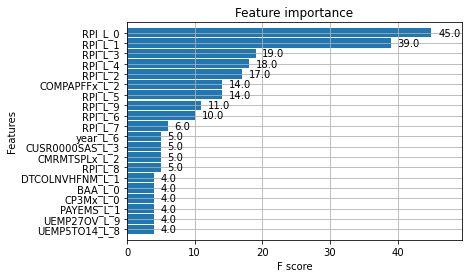

In [14]:
plot_importance(reg, height=0.9,max_num_features=20)


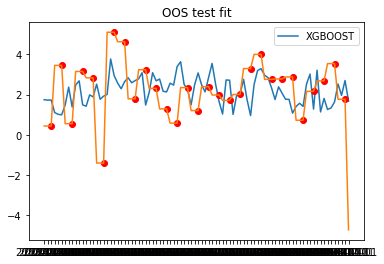

In [12]:
df_test['Prediction'] = reg.predict(X_test)

plt.figure()
#plt.plot(y_test,label="actual")
plt.plot(df_test['Prediction'],label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test['GDPC1'], 'ro')
plt.plot(df_test[target])

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df_test[target],
                   y_pred=df_test['Prediction'])



76.49753645911808

In [11]:

df_test['error'] = df_test[target] - df_test['Prediction']
df_test['abs_error'] = df_test['error'].apply(np.abs)
error_by_day = df_test.groupby(['year','month','dayofmonth']) \
    .mean()[[target,'Prediction','error','abs_error']]
    
error_by_day.sort_values('error', ascending=True).head(10)


GDPC1_continuous  Prediction     error  abs_error
year month dayofmonth                                                   
2020 1     1                  -4.728455    1.676770 -6.405224   6.405224
2014 1     1                  -1.402896    2.519212 -3.922108   3.922108
     3     1                  -1.402896    1.925022 -3.327918   3.327918
     2     1                  -1.402896    1.770525 -3.173421   3.173421
2015 12    1                   0.584510    3.393611 -2.809101   2.809101
     10    1                   0.584510    2.568546 -1.984036   1.984036
     11    1                   0.584510    2.477495 -1.892985   1.892985
2016 6     1                   1.207730    3.079856 -1.872126   1.872126
2013 5     1                   0.557153    2.375117 -1.817964   1.817964
2016 10    1                   1.982634    3.554543 -1.571910   1.571910